# Projet (part 2) : Détection d'anomalies

<b> Auteurs : </b> Damien BOUET, Pierre CHARDIN, Noé DEBROIS et Marion POIRIER<br>
<b> Date : </b> de Septembre 2022 à Janvier 2023<br>
<b> Implication personnelle : </b> 40 heures


Rappel des faits : Nous souhaitons construire un système de détection d'anomalies dans un signal de rayonnement gamma, pour des applications par exemple en surveillance nucléaire. Ce système permettra de détecter en temps réel des potentielles anomalies ou comportements caractéristiques de la mesure du rayonnement gamma. Grâce à la première partie de ce projet (voir 1<sup>er</sup> notebook), nous sommes déjà cabable de détecter des commportements ou anomalies qui se sont déjà produitent dans le passé, et de les classifier. Nous allons maintenant étudier une seconde approche, et évaluer ses performances. Cette seconde approche permettra notamment de détecter toute sorte d'anomalies, qu'elles soients déjà survenues ou non.

Nous modéliserons pour cela, dans un premier temps, la série temporelle à l'aide de réseaux de neurones récurrents LSTM pour réaliser une prédiction à 1 pas. Nous mesurerons ensuite l'erreur de prédiction et en déduirons, grâce à l'implémentation d'un seuillage intelligent (voir Article de la NASA), les potentielles anomalies.

En effet, si le modèle, entrainé sur un signal relativement habituel, s'écarte des valeurs de radiations mesurées, c'est que ces valeurs sortent de l'ordinaire, et sont donc une anomalie.

##### Importations nécessaires

In [2]:
import pandas as pd
import numpy as np
import more_itertools as mit
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from tensorflow.python.keras.layers.core import Dense, Activation, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import save     
from tensorflow.python.keras.models import load_model

import time

# Partie I : Modélisation du signal par un réseau LSTM

## I/ A) Préprocessing

In [291]:
df = pd.read_csv("donnees/2015_months_DebitDoseA.txt")
df.rename(columns = {'24/02/2015 11:20':'FEV', '30/04/2015 13:10':'MAY', '22/06/2015 07:31':'JUN', '20/10/2015 09:18':'OCT'}, inplace = True)
df

,FEV,MAY,JUN,OCT
0,92.8536,96.38690,96.98370,104.8191
1,91.8084,95.68260,96.33440,103.6979
2,93.3221,97.17039,96.67419,104.6446
3,91.7464,97.41650,97.40680,104.3136
4,93.4146,97.39280,97.60400,104.5342
...,...,...,...,...
40314,103.1037,97.12400,101.08090,97.3781
40315,102.4074,98.34760,100.19280,98.0843
40316,103.0529,98.91140,101.56070,99.6903
40317,102.9746,98.82339,101.22470,100.9240


Les mesures des différents mois n'étant pas consécutives, nous ne pouvons pas entrainer le modèle sur plusieurs mois d'un coup. Nous choisissons donc, par exemple, le mois de juin. 

On ajoute aussi une colonne de dates.

In [292]:
dates = pd.date_range(start='2015-04-30 13:10', periods=40319, freq='Min') # 40319
df = df[['JUN']]
df['timestamp'] = pd.to_datetime(dates)

<ipython-input-292-1708ff31c405>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(dates)


#### Visualisation de la série temporelle :

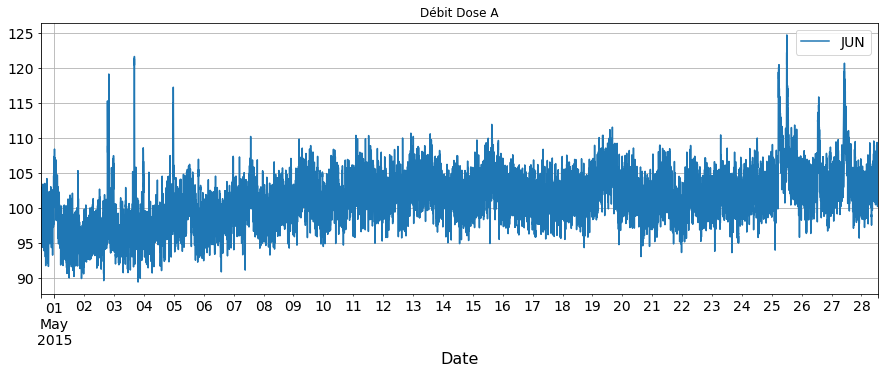

In [293]:
figsize=(15,5)
df.plot(x='timestamp', y='JUN', figsize=figsize, title='Débit Dose A')
plt.xlabel("Date")
plt.grid()
plt.show()

#### Formattage des données pour l'entrée du LSTM :
On donne au réseau de neurone d'autres informations comme l'heure ou le jour de la semaine. Si nous avions par exemple écarté les autres mesures de grandeurs atmosphériques dans la première partie car il était difficile d'en tirer de l'information, il peut être pertinent d'ajouter l'information de l'heure. En effet, la température par exemple varie presque uniquement avec l'heure de la journée (sur une petite échelle de temps). Il peut donc être utile, plutôt que de donner le signal entier de la température, de simplement donner l'heure de la journée.

In [294]:
df['hours'] = df['timestamp'].dt.hour # On ne garde que les heures ; grâce au type de date c'est facile...
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int) # On choisit arbitrairement que les heures du jour sont de 7 à 22h...
df['DayOfTheWeek'] = df['timestamp'].dt.dayofweek # On isole les jours de la semaine (sans le w e)...
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int) # 0 à 4 représentent lundi à vendredi.

df['time_epoch'] = (df['timestamp'].astype(np.int64)/100000000000).astype(np.int64)

df['categories'] = df['WeekDay']*2 + df['daylight'] # Petite astuce pour affecter une valeur de 0 à 3 selon la catégorie (nuit/jour ; sem/we)
a = df.loc[df['categories'] == 0, 'JUN'] # Les multiples de 2 sont la nuit car alors daylight vaut 0...
b = df.loc[df['categories'] == 1, 'JUN'] # 0 : w e nuit...
c = df.loc[df['categories'] == 2, 'JUN'] # 1 : w e jour...
d = df.loc[df['categories'] == 3, 'JUN'] # 2 : semaine nuit...
# 3 : semaine jour.

data_n = df[['JUN', 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
data_n.head()

<ipython-input-294-b5515269f968>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hours'] = df['timestamp'].dt.hour # On ne garde que les heures ; grâce au type de date c'est facile...


,JUN,hours,daylight,DayOfTheWeek,WeekDay
0,96.98370,13,1,3,1
1,96.33440,13,1,3,1
2,96.67419,13,1,3,1
3,97.40680,13,1,3,1
4,97.60400,13,1,3,1


#### Normalisation des données avec "StandardScaler" :

In [295]:
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data_n)

# On remplace data_n par son analogue avec toutes ses valeurs normalisées...
data_n = pd.DataFrame(np_scaled)

#### Paramètres et création du training set et du test set :

In [296]:
# Important parameters and training/Test size
prediction_time = 1 
testdatasize = 5000
unroll_length = 1
testdatacut = testdatasize + unroll_length  + 1

# Training data
x_train = data_n[0:-prediction_time-testdatacut].values # [0;-1-(1000+50+1)]=[0;-1052] = tous sauf les 1052 dernières valeurs (±1...)...
y_train = data_n[prediction_time:-testdatacut  ][0].values # [1;-1051] = idem mais décalé de 1 vers la droite...

# Test data
x_test = data_n[0-testdatacut:-prediction_time].values # [-1051; -1] = les 1051 dernières valeurs (±1...) sauf la TOUTE dernière...
y_test = data_n[prediction_time-testdatacut:  ][0].values # [1-1051;] = [-1050;] = idem mais décalé de 1 vers la droite...

In [297]:
def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return np.asarray(result)

# Adapt the datasets for the sequence data shape
x_train = unroll(x_train,unroll_length)
x_test  = unroll(x_test,unroll_length)
y_train = y_train[-x_train.shape[0]:]
y_test  = y_test[-x_test.shape[0]:]

# Shape of the data
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (35315, 1, 5)
y_train (35315,)
x_test (5000, 1, 5)
y_test (5000,)


Nous transformons les données dans ce format assez particulier car cela est nécessaire pour utiliser l'implémentation de tensorflow du type de réseau que nous allons utiliser.

Les données sont composées de 5 dimensions, car elles contiennent le signal de rayonnement gamma à prédire mais aussi d'autres informations qui sont a disposition du réseau si besoin, comme expliqué précedemment

## I/ B) Création du modèle, entrainement et prédiction

In [298]:
model = Sequential()

model.add(LSTM(input_dim=x_train.shape[-1], units=50, return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=False))
#model.add(Dropout(0.2))

model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, None, 50)          11200     
_________________________________________________________________
lstm_19 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_8 (Activation)    (None, 1)                 0         
Total params: 71,701
Trainable params: 71,701
Non-trainable params: 0
_________________________________________________________________


#### Entraînement du modèle avec x_train et y_train :

In [299]:
model.fit(x_train, y_train, batch_size=3028, epochs=30, validation_split=0.1)

Epoch 1/30
11/11 [==============================] - 4s 97ms/step - loss: 0.8323 - val_loss: 0.4570
Epoch 2/30
11/11 [==============================] - 0s 26ms/step - loss: 0.6845 - val_loss: 0.4723
Epoch 3/30
11/11 [==============================] - 0s 27ms/step - loss: 0.5384 - val_loss: 0.4193
Epoch 4/30
11/11 [==============================] - 0s 26ms/step - loss: 0.3991 - val_loss: 0.2968
Epoch 5/30
11/11 [==============================] - 0s 25ms/step - loss: 0.2900 - val_loss: 0.2233
Epoch 6/30
11/11 [==============================] - 0s 26ms/step - loss: 0.2313 - val_loss: 0.1894
Epoch 7/30
11/11 [==============================] - 0s 26ms/step - loss: 0.2107 - val_loss: 0.1853
Epoch 8/30
11/11 [==============================] - 0s 25ms/step - loss: 0.2045 - val_loss: 0.1876
Epoch 9/30
11/11 [==============================] - 0s 26ms/step - loss: 0.2018 - val_loss: 0.1921
Epoch 10/30
11/11 [==============================] - 0s 25ms/step - loss: 0.2002 - val_loss: 0.1898
Epoch 11/

In [300]:
model.save("model_1.h5")

#### Visualisation des training_loss et validation_loss :

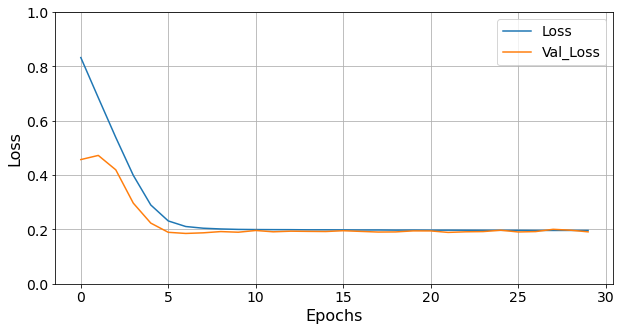

In [301]:
plt.figure(figsize = (10, 5))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['val_loss'], label = 'Val_Loss')
plt.ylim([0,1])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

#### Superposition des données de test et des prédictions :

In [302]:
model = load_model("model_1.h5")

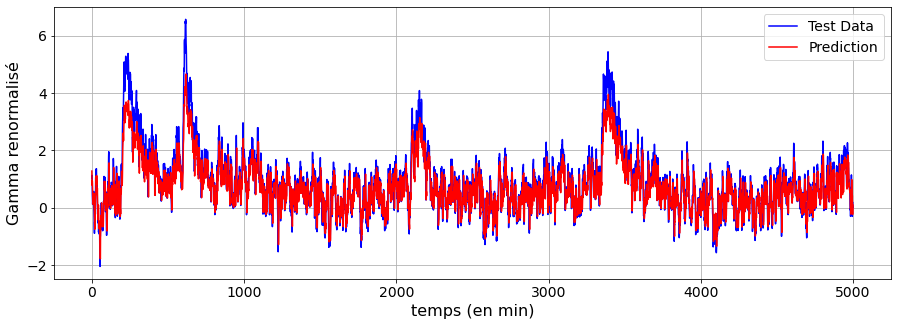

In [303]:
# Creating the list of difference between prediction and test data
loaded_model = model
diff=[]
ratio=[]
p = loaded_model.predict(x_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

# Plotting the prediction and the reality (for the test data)
plt.figure(figsize = (15, 5))
plt.plot(y_test,color='blue', label='Test Data')
plt.plot(p,color='red', label='Prediction')
plt.legend(loc='upper left')
plt.xlabel('temps (en min)')
plt.ylabel("Gamma renormalisé")
plt.grid()
plt.legend()

# Partie II : Détection d'anomalies à partir de la prédiction

## II/ A) Seuillage "trivial"

Dans un premier temps, on regarde les performances d'un seuillage qui consiste simplement à considérer les points les plus éloignés du modèle comme des anomalies. On prend ici les 5% des points les moins bien prédits.

In [304]:
outliers_fraction = 0.05

# Pick the most distant prediction/reality data points as anomalies
diff = pd.Series(diff) # Contient la valeur absolue de l'erreur de prévision...
number_of_outliers = int(outliers_fraction*len(diff)) # C'est le nombre d'anomalies qui dépend linéairement de outliers_fraction (ici à 1%)...
threshold = diff.nlargest(number_of_outliers).min() # threshold = le min des number_of_outliers plus grands éléments de diff...
# I.e c'est le plus petit des écarts des points qu'on considère être des anomalies ; c'est donc bien le threshold... toute erreur de reconstruction
# >= entrainera la classification du point en question comme anomalie.

# Data with anomaly label
test = (diff >= threshold).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
df['anomaly27'] = complement.append(test, ignore_index='True')
print(str(df['anomaly27'].value_counts()[1]) + " anomalies détectées") # Nombre d'anomalies.

28 anomalies détectées


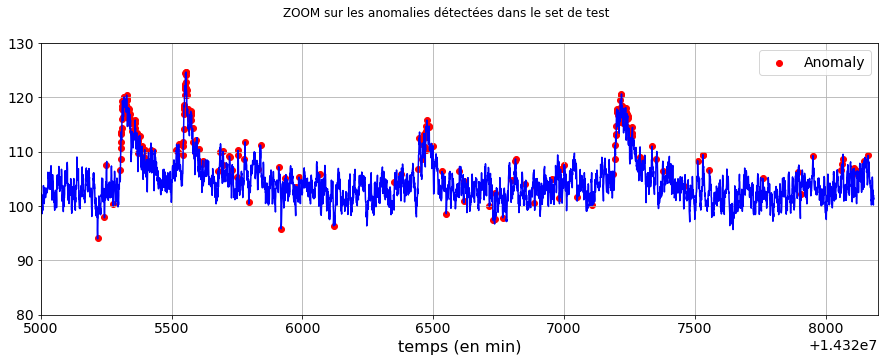

In [305]:
# Zooming on anomalies (Red Dots)
plt.figure(figsize=(15,5))
plt.suptitle("ZOOM sur les anomalies détectées dans le set de test")
a = df.loc[df['anomaly27'] == 1, ['time_epoch', 'JUN']] # anomaly
plt.plot(df['time_epoch'], df['JUN'], color='blue')
plt.scatter(a['time_epoch'],a['JUN'], color='red', label = 'Anomaly')
plt.axis([1.4325*1e7, 1.43282*1e7, 80,130])
plt.xlabel("temps (en min)")
plt.grid()
plt.legend()

On voit que ce seuillage détecte des anomalies un peu partout sur le signal. Ce n'est vraiment pas ce que nous aurions souhaité. Compte tenu du signal (voir en haut du notebook), il serait plus cohérent que ce soit ces 3 ou 4 grands pics qui soient détectés comme des anomalies, et le rest non.

## II/ B) Implémentation du seuillage de l'article de la NASA

#### Paramètres :

In [1]:
# Pour l'EWMA
batch_size = 70
window_size = 30
smoothing_perc = 0.05
# Pour e_a
error_buffer = 2
# Pour l'ensmeble sur lequel est optimisé epsilon
z_min = 2
z_max = 11
#Pour le pruning
prun = 0.13

In [307]:
data = y_test # test data
prediction = p[:,0] # prediction of test data

#### Calcul de l'erreur de prédiction $e$ et de l'erreur lissée $e_s$ :

In [11]:
def errors(data, prediction, batch_size, window_size, smoothing_perc):
    e = np.abs(data-prediction)
    smoothing_window = int(batch_size*window_size*smoothing_perc)
    e_s = pd.DataFrame(e).ewm(span=smoothing_window).mean().values.flatten()
    return e, e_s

e, e_s = errors(data, prediction, batch_size, window_size, smoothing_perc)

#### Check des erreurs :

In [309]:
print('Erreur max',np.max(e))
print('Erreur smoothed max',np.max(e_s))
print('Check :', np.max(e)>np.max(e_s))

Erreur max 2.38207507152746
Erreur smoothed max 0.9957074484158316
Check : True


#### Calcul des indices des erreurs $i_{anom}$ :

In [12]:
def compute_i_anom(e_s, epsilon, error_buffer):
    # Indice des anomalie de l'ensemble de e_a "élargi".
    # e_a est élargi dans le sens où si le point d'indice i est dans e_a,
    # i+1, ..., i+error_buffer-1 et i-1, ..., i - error_buffer + 1 sont dans e_a

    buffer = np.arange(1, error_buffer)
    i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
    i_anom = np.sort(np.concatenate((i_anom,
                                            np.array(
                                                [i+buffer for i in i_anom])
                                             .flatten(),
                                            np.array(
                                                [i-buffer for i in i_anom])
                                             .flatten())))
    i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
    i_anom = np.sort(np.unique(i_anom))
    return i_anom

#### Calcul de $E_{seq}$ : indices de début et de fin des anomalies détectées par le calcul de $i_{anom}$ 

In [13]:
def compute_E_seq(i_anom):
    # E_seq contient les indices de début et de fin de chaque séquence de e_a de longueur supérieure ou égale à 2
    # groups est e_a découpé en liste de séquence consécutive (notamment de longueur 1)
    groups = [list(group) for group
                          in mit.consecutive_groups(i_anom)]
    E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]
    return groups, E_seq

#### Calcul de $\epsilon$ : hauteur du seuil retenu

In [14]:
def compute_epsilon(e_s, z_min, z_max, error_buffer):
    mu_es = np.mean(e_s)
    std_es = np.std(e_s)
    max_score = -np.infty
    max_epsilon = mu_es + z_min*std_es

    for z in range(z_min, z_max):
        epsilon = mu_es + z*std_es
        pruned_e_s = e_s[e_s < epsilon]
        i_anom = compute_i_anom(e_s, epsilon, error_buffer)
    
        if len(i_anom) > 0:
            groups, E_seq = compute_E_seq(i_anom)

            mean_perc_decrease = (mu_es - np.mean(pruned_e_s))/ mu_es
            sd_perc_decrease = (std_es - np.std(pruned_e_s))/std_es
            score = (mean_perc_decrease + sd_perc_decrease)/(len(E_seq) ** 2 + len(i_anom)) # le petit epsilon dans l'article
            
            if score >= max_score and len(E_seq) <= 5: #and len(i_anom) < (len(e_s) * 0.5):
                max_score = score
                max_epsilon = epsilon
                max_E_seq = E_seq
                max_groups = groups
                max_i_anom = i_anom
        
    return max_epsilon, max_score, max_E_seq, max_groups, max_i_anom

In [313]:
epsilon, epsilon_score, E_seq, groups, i_anom = compute_epsilon(e_s, z_min, z_max, error_buffer)

In [314]:
e_s = pd.Series(e_s) # Contient la valeur absolue de l'erreur de prévision...

### Création d'un dataframe pour y_test :

In [315]:
y_test_pd = pd.DataFrame(y_test)
y_test_pd.columns = ["Test Data"]
y_test_pd

,Test Data
0,1.044956
1,1.128082
2,1.009447
3,0.463942
4,0.317776
...,...
4995,-0.054649
4996,-0.304141
4997,0.080139
4998,-0.014252


#### Indentification des anomalies

In [316]:
test = (e_s >= epsilon).astype(int)
complement = pd.Series(0, index=np.arange(len(data_n)-testdatasize))
y_test_pd['anomaly27'] = test
print(str(y_test_pd['anomaly27'].value_counts()[1]) + " anomalies détectées") # Nombre d'anomalies.

323 anomalies détectées


In [317]:
list_idx = np.where(y_test_pd['anomaly27']==1, y_test_pd.index, 0)
x = list_idx[list_idx != 0]

x contient les indices des points de mesure détectés comme étant des anomalies.

## II/ C) Résultats du seuillage implémenté

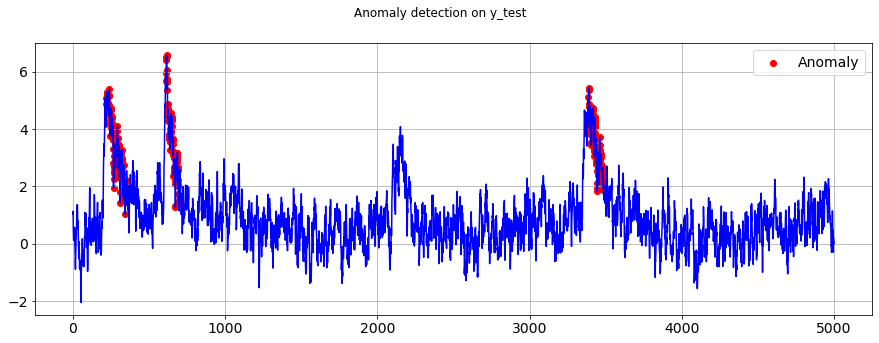

In [318]:
# Visualizing anomalies (Red Dots)
plt.figure(figsize=(15,5))
a = y_test_pd.loc[y_test_pd['anomaly27'] == 1, ['Test Data']] # anomaly
plt.plot(np.arange(testdatasize), y_test, color='blue')
plt.scatter(x,a['Test Data'], color='red', label = 'Anomaly')
plt.grid()
plt.suptitle("Anomaly detection on y_test")
plt.legend()
#plt.xlim(left=600)
#plt.xlim(right=620)

On voit ici le signal de test et, en rouge, les anomalies détectées. On voit que cette fois-ci, ce sont bien les 3 pics qui sont détectés comme des anomalies et le reste du signal est considéré comme normal. La question pourrait se poser pour le 3<sup>ème</sup> pic. Cependant, on voit que, contrairement au 3 autres qui montaient très rapidement puis redescendaient plus calmement, ce pic monte et descend calmement. Il pourrait donc être acceptable qu'il ne soit pas considéré comme une anomalie.

Si cependant, un expert souhaite le détecter comme une anomalie, il serait possible de rnedre le système plus sensible, en changeant certains paramètre.

Cette modélisation, pour la détection des anomalies est donc un succès.

#### Visualisation de l'erreur smoothed :

In [319]:
epsilon_threshold = np.zeros(testdatasize)
for k in range(len(epsilon_threshold)):
    epsilon_threshold[k] = epsilon

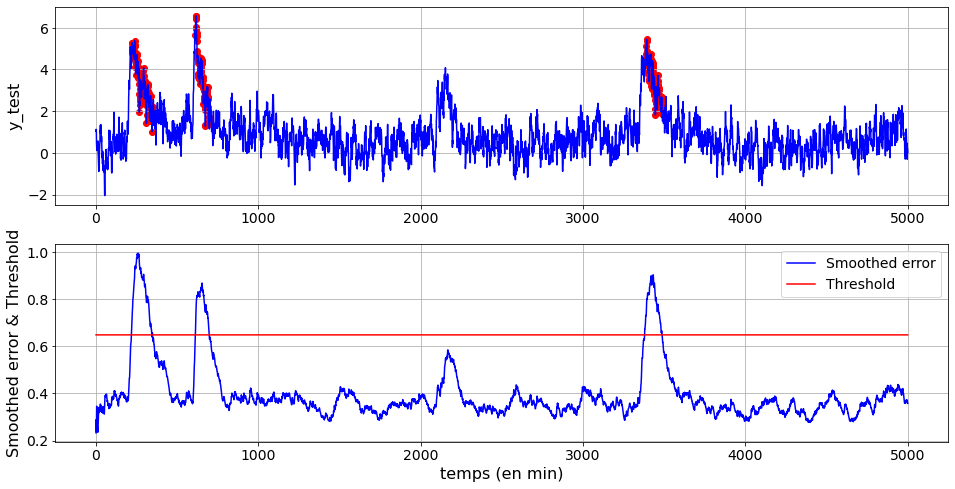

In [320]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
plt.plot(np.arange(testdatasize), y_test, color='blue')
plt.scatter(x,a['Test Data'], color='red', label = 'Anomaly')
plt.ylabel("y_test")
plt.grid()

plt.subplot(2,1,2)
plt.plot(np.arange(testdatasize), e_s, color='blue', label="Smoothed error")
plt.plot(epsilon_threshold, color="red", label="Threshold")
plt.ylabel("Smoothed error & Threshold")
plt.xlabel("temps (en min)")
plt.grid()

plt.legend()
plt.show()

On voit ici l'erreur lissée représentée avec le seuil calculé. On comprend ici comme les anomalies ont été détectées. On voit de plus que le fameux 3<sup>ème</sup> pic a presque été détecté

## II/ D) Pruning

Nous allons ici implémenter la méthode de pruning proposée par la NASA. Pour faire simple, elle consiste à comparer l'écart entre 2 anomalies successives et déduire de cela si ce sont vraiment des anomalies ou pas. Si une anomalie était à peine supérieur au seuil, et qu'elle est négligeable devant l'anomalie suivante, il peut alors être pertient de penser que ce n'était pas vraiemnt une anoamlie : elle sera alors reclassé comme valeur normal, en tant que faux positif.

In [321]:
def compare_to_epsilon(e_s, i_anom):
        assert len(i_anom) < len(e_s)
        i_normal = np.setdiff1d(np.arange(0, len(e_s)), i_anom)
        e_s_normal = e_s[i_normal]
        return np.max(e_s_normal)

In [322]:
def pruning(e_s, E_seq, i_anom, p):
    E_seq_max = np.array([max(e_s[e[0]:e[1]+1]) for e in E_seq])
    E_seq_max_sorted = np.sort(E_seq_max)[::-1]
    non_anom_max = compare_to_epsilon(e_s, i_anom)
    E_seq_max_sorted = np.flip(np.append(E_seq_max_sorted, [non_anom_max]))

    i_to_remove = np.array([])
    for i in range(0, len(E_seq_max_sorted)-1):
        if (E_seq_max_sorted[i+1] - E_seq_max_sorted[i]) \
                    / E_seq_max_sorted[i] < p:
            i_to_remove = np.append(i_to_remove, np.argwhere(E_seq_max == E_seq_max_sorted[i]))
        else:
            break
    i_to_remove[::-1].sort()

    E_seq_pruned = np.copy(E_seq)
    if len(i_to_remove) > 0:
        i_to_remove = i_to_remove.astype(int)
        E_seq_pruned = np.delete(E_seq, i_to_remove, axis=0)

    if len(E_seq_pruned) == 0 :
        i_anom_pruned = np.array([])
    else:
        indices_to_keep = np.concatenate([range(e_seq[0], e_seq[-1]+1) for e_seq in E_seq_pruned])
        mask = np.isin(i_anom, indices_to_keep)
        i_anom_pruned = i_anom[mask]

    return E_seq_pruned, i_anom_pruned

In [323]:
E_seq_pruned, i_anom_pruned = pruning(e_s, E_seq, i_anom, prun)

#### Anomalies détectées après pruning

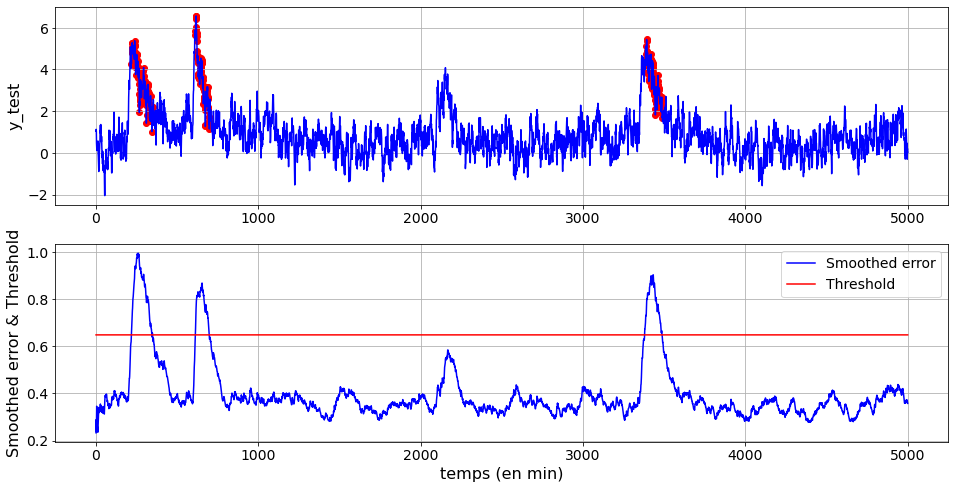

In [324]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
plt.plot(np.arange(testdatasize), y_test, color='blue')
plt.scatter(i_anom_pruned,y_test[i_anom_pruned], color='red', label = 'Anomaly')
# plt.scatter(i_anom,y_test[i_anom], color='red', label = 'Anomaly')
plt.ylabel("y_test")
plt.grid()

plt.subplot(2,1,2)
plt.plot(np.arange(testdatasize), e_s, color='blue', label="Smoothed error")
plt.plot(epsilon_threshold, color="red", label="Threshold")
plt.ylabel("Smoothed error & Threshold")
plt.grid()
plt.xlabel("temps (en min)")
plt.legend()
plt.show()

On voit qu'ici le résultat n'a pas changé, car nos 3 anomalies détectées sont indiscutablement des vraies anomalies. Même si cela n'était pas nécessaire ici, il reste tout de même intéressant d'utiliser cette méthode pour s'assurer que les anomalies détectées ne sont pas des faux-positifs.

# Partie III : Comparaison avec d'autres modèles

Nous allons dans cette partie, évaluer les performances de 2 méthodes de machine learning pour la prédiction du signal. Il convient ici de s'assurer que l'utilisation d'une technologie relativement complexe (le réseau de neurones récurrents LSTM) apporte belle et bien des avantages en terme de performances par rapport à des méthodes de machine learning classiques.

Pour appliquer l'algorithme de Gradient Tree Boosting sur une série temporelle, nous devons fournir à l'algorithme les valeurs passées en tant que features. Pour pouvoir considérer un historique assez lointain sans augmenter irraisonablement le temps de calcul, nous allons sous échantillonner le signal à l'aide d'une moyenne glissante.

### Préprocessing

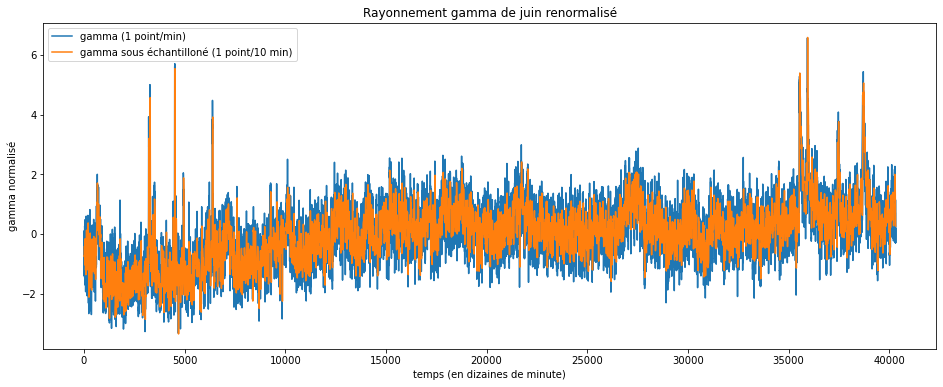

In [3]:
datas = pd.read_csv("donnees_txt_par_mois/2015_gamma.txt")
datas_ech = [None]
mois = "juin" 
df = pd.DataFrame(data={"gamma" : np.array(datas[mois])}) #fevrier, avril, juin, octobre

frec = 10

for i in range(1,len(df)//frec +1):
    datas_ech.append(np.mean(np.array(df["gamma"][max(0,frec*(i-1)):frec*i])))
datas_ech[0] = datas_ech[1]

df_ech = pd.DataFrame(data={"gamma" : np.array(datas_ech)}) #fevrier, avril, juin, octobre


train_mean = df.mean()
train_std = df.std()

train_df = (df - train_mean) / train_std
df_norm = (df - train_mean) / train_std

train_mean = df_ech.mean()
train_std = df_ech.std()

train_df = (df_ech - train_mean) / train_std
df_ech_norm = (df_ech - train_mean) / train_std

plt.figure(figsize = (16,6))
plt.title("Rayonnement gamma de juin renormalisé")
plt.xlabel("temps (en dizaines de minute)")
plt.ylabel("gamma normalisé")
plt.plot(np.arange(0,len(df)),df_norm["gamma"],label="gamma (1 point/min)")
plt.plot(frec//2+frec*np.arange(0,(len(df_ech_norm["gamma"]))),df_ech_norm["gamma"],label="gamma sous échantilloné (1 point/10 min)")
plt.legend()
plt.show()

## III/ A) Première méthode : Gradient Tree Boosting

### III/ A) 1. Entrainement du modèle et prédiction

In [4]:
dico = {}
historic = 720
for i in range(historic):
    dico["J_"+str(i)] = df_ech_norm["gamma"].shift(i).fillna(method="bfill")
df_extend = pd.DataFrame(data=dico)
df_extend

,J_0,J_1,J_2,J_3,J_4,J_5,J_6,J_7,J_8,J_9,...,J_710,J_711,J_712,J_713,J_714,J_715,J_716,J_717,J_718,J_719
0,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,...,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569
1,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,...,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569
2,-0.404854,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,...,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569
3,-1.036609,-0.404854,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,...,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569
4,-0.165316,-1.036609,-0.404854,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,...,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569,-0.749569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4027,1.996259,1.327347,1.205148,1.331421,1.138142,1.179169,0.275252,1.011249,0.861721,1.397088,...,0.063372,0.538831,1.206721,0.560122,0.570356,0.548349,-0.280836,-0.337219,-0.069590,0.173828
4028,1.461593,1.996259,1.327347,1.205148,1.331421,1.138142,1.179169,0.275252,1.011249,0.861721,...,-0.031168,0.063372,0.538831,1.206721,0.560122,0.570356,0.548349,-0.280836,-0.337219,-0.069590
4029,1.711866,1.461593,1.996259,1.327347,1.205148,1.331421,1.138142,1.179169,0.275252,1.011249,...,-0.155911,-0.031168,0.063372,0.538831,1.206721,0.560122,0.570356,0.548349,-0.280836,-0.337219
4030,0.914555,1.711866,1.461593,1.996259,1.327347,1.205148,1.331421,1.138142,1.179169,0.275252,...,0.634551,-0.155911,-0.031168,0.063372,0.538831,1.206721,0.560122,0.570356,0.548349,-0.280836


On utilise ici en entrée des données à 720 dimensions (ce qui est énorme, nous faisons cela pour maximiser la précision, mais nous ne pourrons pas aller plus loin, il faut en effet rester raisonnable, le réseau LSTM était relativement simple, ne comportait pas beaucoup de couche, il faut donc le comparer avec des méthodes de complexité similaires)

Cela correspond à 5 jours d'historique, car il y a maintenant un point toute les 10 minutes

In [5]:


y = df_extend['J_0']
#X = data[['Generator_converter_speed','Rotor_speed','Hub_temperature','Generator_speed','Grid_voltage_std']] #, 'Generator_converter_speed_std' ,'WT2','WT3','WT4'


X = df_extend.drop(columns=["J_0"],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2*33319/40319, 
                                                    random_state=42,
                                                    shuffle=False)

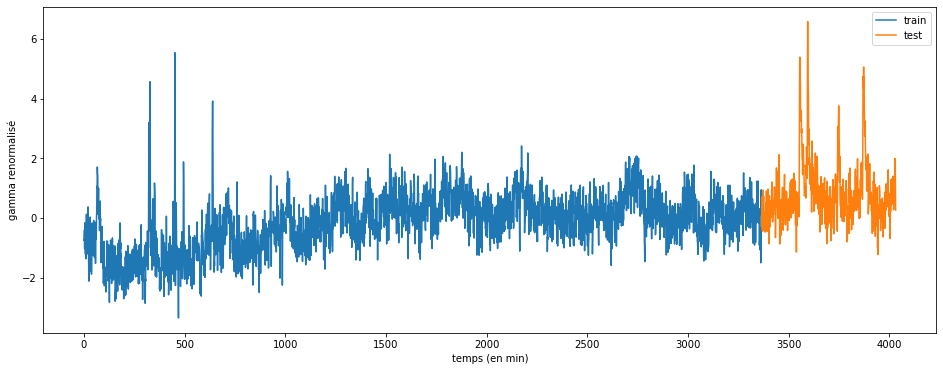

In [6]:
plt.figure(figsize = (16,6))
plt.plot(np.arange(0,len(y_train)),y_train,label="train")
plt.plot(len(y_train)+np.arange(0,len(y_test)),y_test,label="test")
plt.legend()
plt.xlabel("temps (en min)")
plt.ylabel("gamma renormalisé")
plt.show()

In [7]:
params = {
    "n_estimators": 30,
    "max_depth":40,
    #"min_samples_split": 5,
    "learning_rate": 0.1,
    "verbose":1,
    #"loss": "squared_error",
}

reg = GradientBoostingRegressor(**params)

reg.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.6737           50.49s
         2           0.5457           47.63s
         3           0.4420           45.70s
         4           0.3580           44.24s
         5           0.2900           42.44s
         6           0.2349           40.85s
         7           0.1903           39.35s
         8           0.1541           37.50s
         9           0.1249           35.62s
        10           0.1011           34.03s
        20           0.0123           17.01s
        30           0.0015            0.00s


GradientBoostingRegressor(max_depth=40, n_estimators=30, verbose=1)

In [8]:
# Predict the result on training data
pred_train = reg.predict(X_train)
# Predict the result on test data
pred_test = reg.predict(X_test)

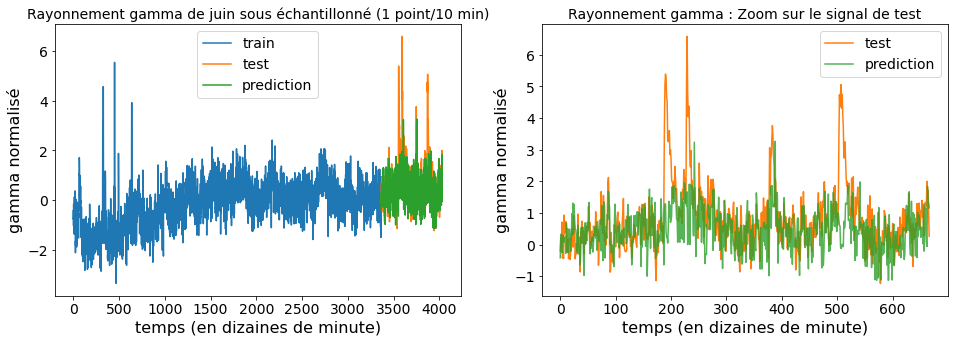

In [47]:
fig, axs = plt.subplots(1, 2,figsize = (16,5))

axs[0].set_title("Rayonnement gamma de juin sous échantillonné (1 point/10 min)",fontsize=14)
axs[0].set_xlabel("temps (en dizaines de minute)")
axs[0].set_ylabel("gamma normalisé")
axs[0].plot(np.arange(0,len(y_train)),y_train,label="train")
axs[0].plot(len(y_train)+np.arange(0,len(y_test)),y_test,label="test")
axs[0].plot(len(y_train)+np.arange(0,len(y_test)),pred_test,label="prediction")
axs[0].legend()

axs[1].set_title("Rayonnement gamma : Zoom sur le signal de test",fontsize=14)
axs[1].set_xlabel("temps (en dizaines de minute)")
axs[1].set_ylabel("gamma normalisé")
axs[1].plot(np.arange(0,len(pred_test)),y_test,label="test",color="tab:orange")
axs[1].plot(np.arange(0,len(pred_test)),pred_test, label="prediction",color="tab:green",alpha=0.8)
axs[1].legend()

plt.show()

On voit que le signal semble être bien modélisé, sauf au niveau des pics. C'est bon signe, car l'erreur de préiction sera donc grande au niveau des pics, il y a donc de grande chances qu'ils soient bien détectés comme des anomalies.

### III/ A) 2. Application à la détection d'anomalies

On utilise exactement la même méthode que précédemment, la seule différence est que cette fois ci, la prédiction vient de l'algorithme de Gradient Tree Boosting, et non pas du réseau LSTM.

24 anomalies détectées


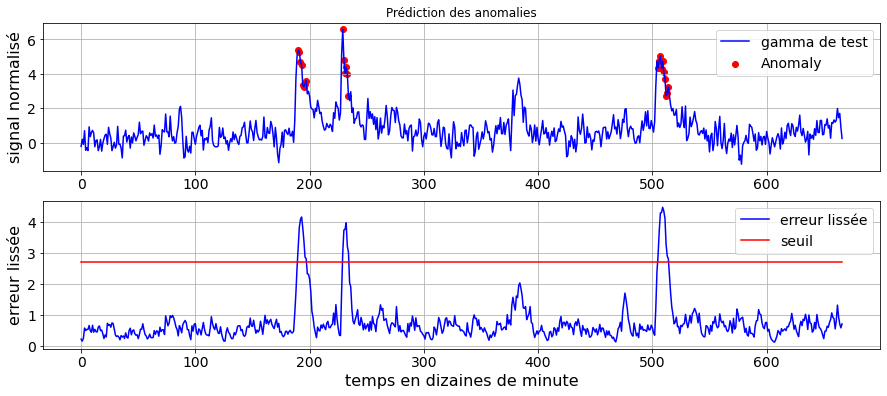

In [30]:
#Paramètres
batch_size = 14
window_size = 6
smoothing_perc = 0.05
error_buffer = 2
z_min = 2
z_max = 11
p = 0.13

data = y_test.values # test data
prediction = pred_test # prediction of test data

e, e_s = errors(data, prediction, batch_size, window_size, smoothing_perc)

epsilon, epsilon_score, E_seq, groups, i_anom = compute_epsilon(e_s, z_min, z_max, error_buffer) 

e_s = pd.Series(e_s) # Contient la valeur absolue de l'erreur de prévision...

y_test_pd = pd.DataFrame(data)
y_test_pd.columns = ["Test Data"]

testdatasize = len(data)

test = (e_s >= epsilon).astype(int)
complement = pd.Series(0, index=np.arange(len(y_train)))
y_test_pd['anomaly27'] = test
print(str(y_test_pd['anomaly27'].value_counts()[1]) + " anomalies détectées") # Nombre d'anomalies.
a = y_test_pd.loc[y_test_pd['anomaly27'] == 1, ['Test Data']] # anomaly
list_idx = np.where(y_test_pd['anomaly27']==1, y_test_pd.index, 0)
x = list_idx[list_idx != 0]

epsilon_threshold = np.zeros(testdatasize)
for k in range(len(epsilon_threshold)):
    epsilon_threshold[k] = epsilon

plt.figure(figsize = (15,6))

plt.subplot(2,1,1)
plt.plot(np.arange(testdatasize), data, color='blue', label="gamma de test")
plt.scatter(x,a['Test Data'], color='red', label = 'Anomaly')
plt.ylabel("signal normalisé")
plt.legend()
plt.title("Prédiction des anomalies")
plt.grid()

plt.subplot(2,1,2)
plt.plot(np.arange(testdatasize), e_s, color='blue', label="erreur lissée")
plt.plot(epsilon_threshold, color="red", label="seuil")
plt.ylabel("erreur lissée")
plt.xlabel("temps en dizaines de minute")
plt.grid()

plt.legend()
plt.show()

On remarque que si globalement les 3 pics ont été détectés, la fin des pics n'est systèmétiquement pas détectées. Cette méthode est donc moins permormante que le réseau LSTM (d'autant plus que nous avons dû utiliser des données en entrées de très grandes dimensions, pour avoir un historic assez lointain, ce qui entraine un temps de calcul plus long que le LSTM pour de moins bonnes performances)

## III/ B) Deuxième méthode : ARIMA

In [55]:
df_train = df_ech_norm["gamma"][:-int(round(0.2*33319/40319*(len(df_ech_norm))))]
df_test = df_ech_norm["gamma"][-int(round(0.2*33319/40319*(len(df_ech_norm)))):]

df_train = pd.DataFrame(df_train.values,columns=["gamma"])
donnes = []
for x in df_train.values:
    donnes.append(x[0])
donnes = np.array(donnes)

### III/ B) 1. Selection des paramètres du modèle

Un modèle ARIMA est composé de 2 partie, la partie AR et la partie MA, pour lesquels ils faut choisir un paramètre p et q.

En effet, la partie AR est caractérisée de la façon suivante : <br>
$ Y_t = \alpha + \beta _1 Y_{t-1} +\beta _2 Y_{t-2} + ... + \beta _p Y_{t-p} + \varepsilon _ t $

et la partie MA : <br>
$ Y_t = \alpha + \varepsilon _{t-1} \phi_{t-1} +\varepsilon _{t-2} \phi_{t-2} + ... + \varepsilon _{t-q} \phi_{t-q} $

On voit donc que la prédiction se fait à l'aide de p valeurs précédentes et de q erreurs de prédiction précédentes. Trouvons ces valeurs de p et q optimales.

#### III/ B) 1. a) Selection de l'ordre de différentiation d 

Pour appliquer le modèle, il faut que la série soit stationnaire, on la dérive d fois jusqu'à ce qu'elle le devienne

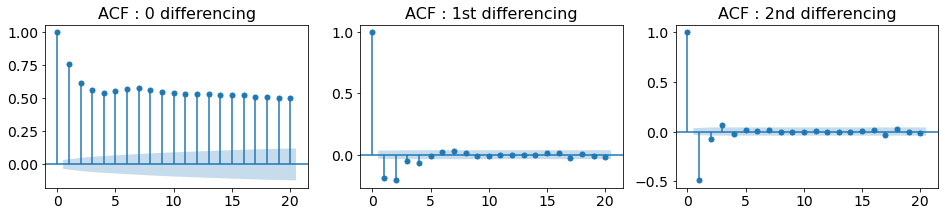

In [56]:
fig, axs = plt.subplots(1, 3,figsize = (16,3))

plot_acf(donnes,ax = axs[0],lags=20,title="ACF : 0 differencing")
plot_acf(np.diff(donnes),ax = axs[1],lags=20,title="ACF : 1st differencing")
plot_acf(np.diff(np.diff(donnes)),ax = axs[2],lags=20,title="ACF : 2nd differencing")

plt.show()

Il faut que l'ACF tende rapidement vers des petites valeurs, pour que la série soit stationnaire, donc on choisit d=1

#### III/ B) 1. b) Selection de p

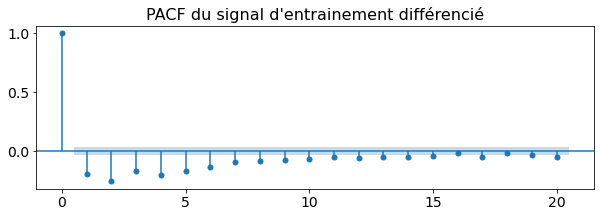

In [57]:
plt.rcParams.update({'figure.figsize':(10,3)})
plot_pacf(np.diff(donnes),lags=20,title="PACF du signal d'entrainement différencié")
plt.show()

Il faut choisir le nombre de pics pour lesquels la PACF est grande en valeur absolue. On pourrait choisir p=2, même si les pics suivant sont encore non négligeable. Nous calculerons par la suite l'AIC pour trouver le meilleur modèle.

#### III/ B) 1. c) Selection de q

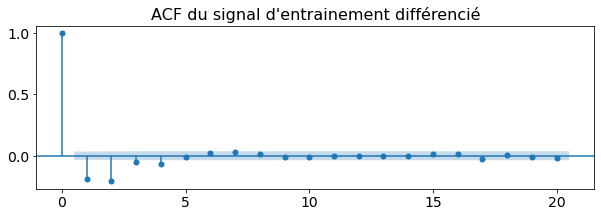

In [58]:
plot_acf(np.diff(donnes),lags=20,title="ACF du signal d'entrainement différencié")
plt.show()

On fait pareil mais avec l'ACF. On prend ici aussi q=2

#### III/ B) 1. d) Entrainement du modèle

In [59]:
model = ARIMA(donnes, order=(2,1,2))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3366
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2780.588
Date:                Sun, 12 Feb 2023   AIC                           5571.175
Time:                        08:40:14   BIC                           5601.781
Sample:                             0   HQIC                          5582.120
                               - 3366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6287      0.140      4.496      0.000       0.355       0.903
ar.L2         -0.1820      0.066     -2.767      0.006      -0.311      -0.053
ma.L1         -1.0500      0.141     -7.436      0.0

### III/ B) 2. Prédiction

Maintenant qu'on a les valeurs des paramètres des partie AR et MA (en dernières lignes du model.summary), on peut reconstruire la prédiction à 1 pas à partir des formules décrites précédemment

In [60]:
history = [x for x in df_train["gamma"].values]
predictions = list()

ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
resid = list(model_fit.resid)

def predict(coef, history):
    yhat = 0
    for i in range(1, len(coef)+1):
        yhat += coef[i-1] * history[-i]
    return yhat

def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return np.array(diff)



for t in range(df_test.index[0],df_test.index[-1]+1):
    diff = difference(history)
    yhat = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
    predictions.append(yhat)
    obs = df_test[t]
    history.append(obs)
    resid.append(obs-yhat)


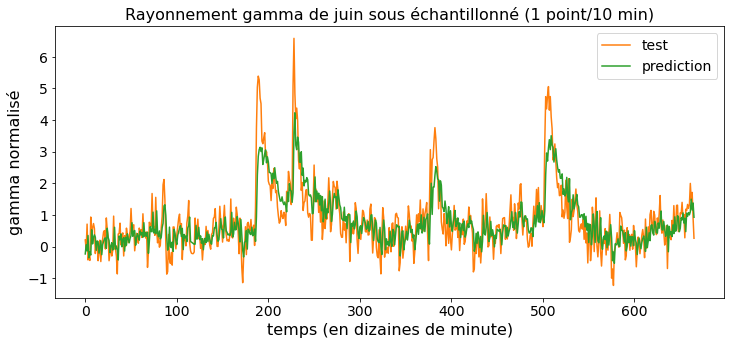

In [61]:
plt.figure(figsize=(12,5))
plt.plot(df_test.values,label="test",color="tab:orange")
plt.plot(predictions, label="prediction",color="tab:green")
plt.title("Rayonnement gamma de juin sous échantillonné (1 point/10 min)")
plt.xlabel("temps (en dizaines de minute)")
plt.ylabel("gamma normalisé")
plt.legend()
plt.show()

On voit que cette prédiction suit très bien la tendance du signal, mais cela même lors des pics. On peut donc s'attendre à ce que la détection d'anomalies soit moins bonne, car l'erreur de prédiction sur les pics ne sera pas très grande.

### III/ B) 3. Application à la détection d'anomalies

On utilise exactement la même méthode que précédemment, la seule différence est que cette fois ci, la prédiction vient de l'algorithme d'ARIMA', et non pas du réseau LSTM.

13 anomalies détectées


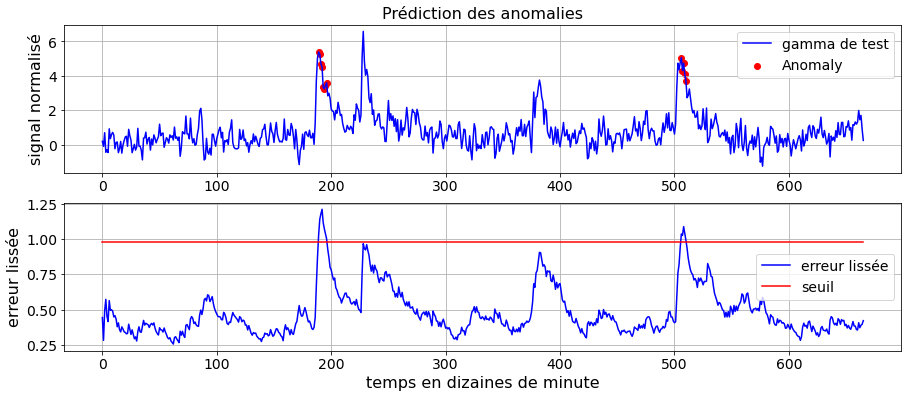

In [68]:
#Paramètres
batch_size = 20
window_size = 20
smoothing_perc = 0.05
error_buffer = 2
z_min = 2
z_max = 11
p = 0.13

data = df_test.values # test data
prediction = predictions # prediction of test data

e, e_s = errors(data, prediction, batch_size, window_size, smoothing_perc)

epsilon, epsilon_score, E_seq, groups, i_anom = compute_epsilon(e_s, z_min, z_max, error_buffer) 

e_s = pd.Series(e_s) # Contient la valeur absolue de l'erreur de prévision...

y_test_pd = pd.DataFrame(data)
y_test_pd.columns = ["Test Data"]

testdatasize = len(data)

test = (e_s >= epsilon).astype(int)
complement = pd.Series(0, index=np.arange(len(y_train)))
y_test_pd['anomaly27'] = test
print(str(y_test_pd['anomaly27'].value_counts()[1]) + " anomalies détectées") # Nombre d'anomalies.
a = y_test_pd.loc[y_test_pd['anomaly27'] == 1, ['Test Data']] # anomaly
list_idx = np.where(y_test_pd['anomaly27']==1, y_test_pd.index, 0)
x = list_idx[list_idx != 0]

epsilon_threshold = np.zeros(testdatasize)
for k in range(len(epsilon_threshold)):
    epsilon_threshold[k] = epsilon

plt.figure(figsize = (15,6))

plt.subplot(2,1,1)
plt.plot(np.arange(testdatasize), data, color='blue', label="gamma de test")
plt.scatter(x,a['Test Data'], color='red', label = 'Anomaly')
plt.ylabel("signal normalisé")
plt.legend()
plt.title("Prédiction des anomalies")
plt.grid()

plt.subplot(2,1,2)
plt.plot(np.arange(testdatasize), e_s, color='blue', label="erreur lissée")
plt.plot(epsilon_threshold, color="red", label="seuil")
plt.ylabel("erreur lissée")
plt.xlabel("temps en dizaines de minute")
plt.grid()

plt.legend()
plt.show()

En effet, on peut voir que les pics n'ont pas du tout bien été détectés. Seuls 2 pics sur les 3 ou 4 (selon qu'on considère le 3<sup>ème</sup> comme une anomalie ou pas) ont été détectés et il n'ont que le début qui a été détecté. Cette méthode est donc la moins efficace.

# Conclusion
## I/ Modélisation du signal par un réseau LSTM
Nous avons modélisé le signal de rayonnement gamma par un réseau de neurones récurrents LSTM à deux couches. La prédiction est très satisfaisante. En effet, le sigal semble très bien modélisé, sauf peut-être lors des pics, que le modèle à plus de mal à prédire : c'est excatement ce qu'on voulait, le modèle prédit très bien le signal dans son comportement normal, et lorsque celui-ci fait des mouvements inhabituels, sa valeur s'écarte du modèle.

## II/ Détection d'anomalies à partir de la prédiction
Nous avons implémenter une méthode de seuillage intelligent (présenté dans l'article de la NASA), pour prédire les anomalies en fonction de l'erreur de prédiction du modèle. Les résultats sont excellents. La méthode de pruning que nous avons aussi implémentée n'a pas été utile dans ce cas là mais elle fonctionne.

## III/ Comparaison avec d'autres modèles
Nous avons ensuite comparé les performances obtenues avec celles qu'on auraient obtenues en utilisant d'autres modèles prédictifs. Même si notre réseau LSTM est relativement simple, et ne nécessite que quelques seconde d'entrainement, nous voulions nous assurer que l'utilisation de cette technologie avancée était justifiée. Les résultats donnés par les méthodes de Gradient Tree Boosting et d'ARIMA sont beaucoup moins bons que ceux du réseau LSTM. Il était donc bien pertient d'utiliser ce réseau, qui s'emble être le plus adapté à notre problème.
        

Ainsi, notre système de détection d'anomalies est très performant. Les objectifs fixés en fin de première partie (voir 1<sup>er</sup> notebook) ont tous été rempli. Notre système est donc belle et bien maitenant capable de :
- détecter des anoamlies en temps réel  (2<sup>ème</sup> partie)
- les classifier  (1<sup>ère</sup> partie)
- analyser l'historique pour une meilleure compréhension des phénomènes (1<sup>ère</sup> partie)